# CS 7641 Machine Learning
# Assignment 2 Randomized Optimization

## Neural Network Weight Optimization : SUMMARY

In [7]:
#
# 0. Import Packages
#

RANDOM_SEED = 27

# Math tools for ML
import numpy as np
import pandas as pd
import math
import time
import copy
from numpy import arange

# Randomized Optimization 
import mlrose_hiive

# Progress bar
#from tqdm import tqdm

# Graph visualization
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import torch
import torch.nn as nn
#import torch.optim as optim
#import tqdm

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# Model 
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import AdaBoostClassifier # Boosted Decision Tree
from sklearn.svm import SVC # SVM
from sklearn.neighbors import KNeighborsClassifier # KNN

#from sklearn import tree

import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler


In [8]:
#
# 1. Data Preparation
#

df = pd.read_csv("./data/dropout.csv", sep=";")
df.info()

# Target 데이터 분석 및 제거
num_droupout = df.query('Target=="Dropout"')
print(len(num_droupout))
num_enrolled = df.query('Target=="Enrolled"')
print(len(num_enrolled))
num_graduated = df.query('Target=="Graduate"')
print(len(num_graduated))

# Enrolled 데이타 삭제 (pending)
df = df.drop(df[df['Target'] == "Enrolled"].index)

# pandas dataframe replace (from https://heytech.tistory.com/441)
df["Target"].replace({'Dropout':0, 'Graduate':1}, inplace = True)
print(df["Target"])

X_raw = df.values[:,:-1]
y_raw = df.values[:,-1]

print("x_raw dimension: ", X_raw.shape)
print("y_raw dimension: ", y_raw.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [15]:
#
# 1.2 Split train and test sets
#

# data type change 
#y_raw = y_raw.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, stratify=y_raw, test_size=0.2, random_state=RANDOM_SEED)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

# print # of X_train
print(y_train_hot.shape)
print(y_test_hot.shape)

(2904, 2)
(726, 2)


In [16]:
max_attempts = [ 1, 5, 10, 15, 20]

blanks = [0 for i in range(len(max_attempts))]

data = { "Max_attempts": max_attempts, 
        "RHC": blanks,
        "SA": blanks, 
        "GA": blanks,
       }

accuracy_df = pd.DataFrame(data)
duration_df = pd.DataFrame(data)

In [19]:
# Randomized Hill Climbing

# best parameters
max_iter = 2000
restart = 40

for max_attempt in max_attempts:
    start_time = time.perf_counter()
    kfold = KFold(n_splits=5, shuffle=True)
    cv_scores  = []
            
    start_time = time.perf_counter()
    nn_model = mlrose_hiive.NeuralNetwork(hidden_nodes = [2], 
                                                  activation = 'relu' ,
                                                  algorithm = 'random_hill_climb',
                                                  is_classifier = True,
                                                  early_stopping = True,
                                                  random_state = RANDOM_SEED,
                                                  max_attempts = max_attempt,
                                                  max_iters = max_iter,
                                                  restarts = restart)

    for train, validate in kfold.split(X_train_scaled, y_train_hot):
        nn_model.fit(X_train_scaled[train], y_train_hot[train])
        y_pred_hot = nn_model.predict(X_train_scaled[validate])
        accuracy = mt.accuracy_score(np.asarray(y_pred_hot), np.asarray(y_train_hot[validate]))
        cv_scores.append(accuracy)
            
    train_time = time.perf_counter() - start_time

    accuracy_train = np.mean(cv_scores)
    
    with torch.no_grad():
        y_pred_hot = nn_model.predict(X_test_scaled)
    accuracy_test = mt.accuracy_score(np.asarray(y_test_hot), np.asarray(y_pred_hot))
        
    accuracy_df.loc[accuracy_df["Max_attempts"] == max_attempt, "RHC"] = accuracy_test
    duration_df.loc[duration_df["Max_attempts"] == max_attempt, "RHC"] = train_time
    print("max_attempt: ", max_attempt, "accuracy_test: ", accuracy_test, "train_time: ", train_time)

print(accuracy_df)
print(duration_df)

accuracy_df.to_csv('nn_summary_accuracy.csv')
duration_df.to_csv('nn_summary_duration.csv')


max_attempt:  1 accuracy_test:  0.6349862258953168 train_time:  0.8685930829997233
max_attempt:  5 accuracy_test:  0.6955922865013774 train_time:  12.338534791999791
max_attempt:  10 accuracy_test:  0.8801652892561983 train_time:  197.41445162499986
max_attempt:  15 accuracy_test:  0.8856749311294766 train_time:  479.9132156249998
max_attempt:  20 accuracy_test:  0.8925619834710744 train_time:  543.2704136670009
   Max_attempts       RHC  SA  GA
0             1  0.634986   0   0
1             5  0.695592   0   0
2            10  0.880165   0   0
3            15  0.885675   0   0
4            20  0.892562   0   0
   Max_attempts         RHC  SA  GA
0             1    0.868593   0   0
1             5   12.338535   0   0
2            10  197.414452   0   0
3            15  479.913216   0   0
4            20  543.270414   0   0


In [21]:
# Simulated Annealing

# best parameters
max_iter = 2000

for max_attempt in max_attempts:
    start_time = time.perf_counter()
    kfold = KFold(n_splits=5, shuffle=True)
    cv_scores  = []
            
    start_time = time.perf_counter()
    nn_model = mlrose_hiive.NeuralNetwork(hidden_nodes = [2], 
                                                  activation = 'relu' ,
                                                  algorithm = 'simulated_annealing',
                                                  is_classifier = True,
                                                  early_stopping = True,
                                                  random_state = RANDOM_SEED,
                                                  max_attempts = max_attempt,
                                                  max_iters = max_iter)

    for train, validate in kfold.split(X_train_scaled, y_train_hot):
        nn_model.fit(X_train_scaled[train], y_train_hot[train])
        y_pred_hot = nn_model.predict(X_train_scaled[validate])
        accuracy = mt.accuracy_score(np.asarray(y_pred_hot), np.asarray(y_train_hot[validate]))
        cv_scores.append(accuracy)
            
    train_time = time.perf_counter() - start_time

    accuracy_train = np.mean(cv_scores)
    
    with torch.no_grad():
        y_pred_hot = nn_model.predict(X_test_scaled)
    accuracy_test = mt.accuracy_score(np.asarray(y_test_hot), np.asarray(y_pred_hot))
        
    accuracy_df.loc[accuracy_df["Max_attempts"] == max_attempt, "SA"] = accuracy_test
    duration_df.loc[duration_df["Max_attempts"] == max_attempt, "SA"] = train_time
    print("max_attempt: ", max_attempt, "accuracy_test: ", accuracy_test, "train_time: ", train_time)

print(accuracy_df)
print(duration_df)

accuracy_df.to_csv('nn_summary_accuracy.csv')
duration_df.to_csv('nn_summary_duration.csv')


max_attempt:  1 accuracy_test:  0.5523415977961432 train_time:  1.9568966670003647
max_attempt:  5 accuracy_test:  0.7975206611570248 train_time:  19.960453000000598
max_attempt:  10 accuracy_test:  0.8126721763085399 train_time:  18.937802624999676
max_attempt:  15 accuracy_test:  0.8071625344352618 train_time:  19.76194279200081
max_attempt:  20 accuracy_test:  0.7988980716253443 train_time:  20.67739524999979
   Max_attempts       RHC        SA        GA
0             1  0.634986  0.552342  0.391185
1             5  0.695592  0.797521  0.391185
2            10  0.880165  0.812672  0.000000
3            15  0.885675  0.807163  0.000000
4            20  0.892562  0.798898  0.000000
   Max_attempts         RHC         SA         GA
0             1    0.868593   1.956897   3.457757
1             5   12.338535  19.960453  18.666379
2            10  197.414452  18.937803   0.000000
3            15  479.913216  19.761943   0.000000
4            20  543.270414  20.677395   0.000000


In [23]:
# Genetic Algorithm

# best parameters
max_iter = 2000
mutation_prob = 0.20
pop_size = 200

for max_attempt in max_attempts:
    start_time = time.perf_counter()
    kfold = KFold(n_splits=5, shuffle=True)
    cv_scores  = []
            
    start_time = time.perf_counter()
    nn_model = mlrose_hiive.NeuralNetwork(hidden_nodes = [2], 
                                                  activation = 'relu' ,
                                                  algorithm = 'genetic_alg',
                                                  is_classifier = True,
                                                  early_stopping = True,
                                                  random_state = RANDOM_SEED,
                                                  max_attempts = max_attempt,
                                                  max_iters = max_iter,
                                                 mutation_prob = mutation_prob, 
                                                 pop_size = pop_size)

    for train, validate in kfold.split(X_train_scaled, y_train_hot):
        nn_model.fit(X_train_scaled[train], y_train_hot[train])
        y_pred_hot = nn_model.predict(X_train_scaled[validate])
        accuracy = mt.accuracy_score(np.asarray(y_pred_hot), np.asarray(y_train_hot[validate]))
        cv_scores.append(accuracy)
            
    train_time = time.perf_counter() - start_time

    accuracy_train = np.mean(cv_scores)
    
    with torch.no_grad():
        y_pred_hot = nn_model.predict(X_test_scaled)
    accuracy_test = mt.accuracy_score(np.asarray(y_test_hot), np.asarray(y_pred_hot))
        
    accuracy_df.loc[accuracy_df["Max_attempts"] == max_attempt, "GA"] = accuracy_test
    duration_df.loc[duration_df["Max_attempts"] == max_attempt, "GA"] = train_time
    print("max_attempt: ", max_attempt, "accuracy_test: ", accuracy_test, "train_time: ", train_time)

print(accuracy_df)
print(duration_df)

accuracy_df.to_csv('nn_summary_accuracy.csv')
duration_df.to_csv('nn_summary_duration.csv')


max_attempt:  1 accuracy_test:  0.3939393939393939 train_time:  3.309625416999552
max_attempt:  5 accuracy_test:  0.39118457300275483 train_time:  14.654742916000032
max_attempt:  10 accuracy_test:  0.39118457300275483 train_time:  24.22465345799992
max_attempt:  15 accuracy_test:  0.39118457300275483 train_time:  60.81108670799949
max_attempt:  20 accuracy_test:  0.39118457300275483 train_time:  59.303436999999576
   Max_attempts       RHC        SA        GA
0             1  0.634986  0.552342  0.393939
1             5  0.695592  0.797521  0.391185
2            10  0.880165  0.812672  0.391185
3            15  0.885675  0.807163  0.391185
4            20  0.892562  0.798898  0.391185
   Max_attempts         RHC         SA         GA
0             1    0.868593   1.956897   3.309625
1             5   12.338535  19.960453  14.654743
2            10  197.414452  18.937803  24.224653
3            15  479.913216  19.761943  60.811087
4            20  543.270414  20.677395  59.303437


<Figure size 640x480 with 0 Axes>

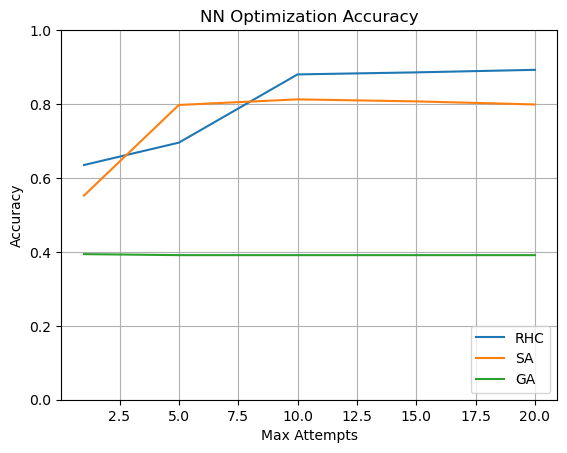

In [24]:
plt.style.use('default')
plt.figure()

accuracy_df.plot(x='Max_attempts')
plt.legend(loc='lower right')
plt.xlabel('Max Attempts')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.title('NN Optimization Accuracy')
plt.grid(True)

plt.show()

<Figure size 640x480 with 0 Axes>

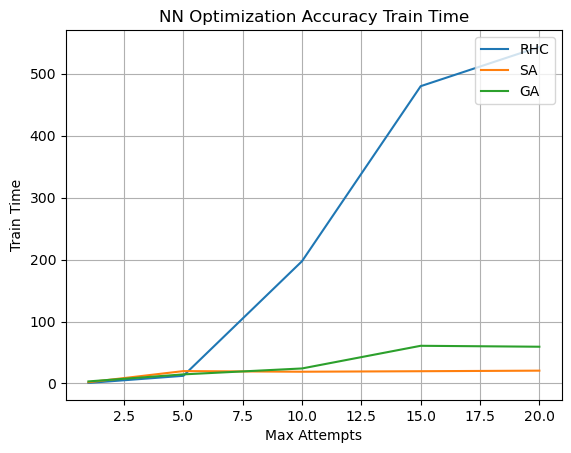

In [25]:
plt.style.use('default')
plt.figure()

duration_df.plot(x='Max_attempts')
plt.legend(loc='upper right')
plt.xlabel('Max Attempts')
plt.ylabel('Train Time')
#plt.ylim(50, 100)
plt.title('NN Optimization Accuracy Train Time')
plt.grid(True)

plt.show()